<a href="https://colab.research.google.com/github/Bepo2002/Humbug-4YP/blob/main/Test_bench_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Bench V2

### Using mel-spectrograms instead of average mel coefficients

## Functions

In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import tensorflow as tf

In [2]:
# Finds specific sound in zip and extracts it
def extract_sound(filename):
  zip_files = ['./drive/MyDrive/4YP/train.zip','./drive/MyDrive/4YP/dev.zip']
  folders = ['train/', 'dev/a/', 'dev/b/']
  dest_dir = './drive/MyDrive/4YP/Data'
  filename_to_extract = str(filename) + '.wav'

  for zip_path in zip_files:
    for folder in folders:
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        filename_to_extract = folder + filename_to_extract
        if filename_to_extract in zip_ref.namelist():
          zip_ref.extract(filename_to_extract, dest_dir)
          print(f"{filename_to_extract} has been extracted to {dest_dir}")
          final = './drive/MyDrive/4YP/Data/'+ filename_to_extract
          return wavfile.read(final)
  print(f"{filename_to_extract} not found in any of the provided ZIP files.")

# Read in .csv
def csv_read():
  metadata = pd.read_csv('./drive/MyDrive/4YP/Data/humbugdb_zenodo_edited.csv')
  metadata = metadata.set_index('id')
  return metadata

def gaussian(x, mu, sigma):
  return np.exp(-((x - mu)**2) / (2 * sigma**2))

# Normalise audio
def normalize_audio(audio, target_dBFS=0):
  # Calculate the current dBFS of the audio
  rms = np.sqrt(np.mean(np.square(audio)))
  current_dBFS = 20 * np.log10(rms)

  # Calculate the required gain to achieve the target dBFS
  gain = target_dBFS - current_dBFS

  # Apply gain to the audio data
  normalized_audio = audio * (10 ** (gain / 20))

  return normalized_audio

In [3]:
# Full function for generating noise + mosquito
def long_sound_gen(mos_num,noise_factor=1):
  metadata = csv_read()

  # Choose a long noise sound
  subset = metadata[(metadata['sound_type'] == 'background') &
                  (metadata['length'] > 10) &
                  (metadata['sample_rate'] == 44100) &
                  (metadata['clean'] == "Y")]

  noise_id = subset.sample().index.values[0]

  # Extract the sound wave and find samplerate
  n_samplerate, noise = extract_sound(noise_id)

  # Normalise
  noise = normalize_audio(noise/100)

  # Choose a shorter mosquito sound
  subset = metadata[(metadata['sound_type'] == 'mosquito') &
                    (metadata['length'] < 10) &
                    (metadata['length'] > 1) &
                    (metadata['sample_rate'] == 44100)]

  mos_id = subset.sample().index.values[0]

  # Import the sound wave and find samplerate
  samplerate, data = extract_sound(mos_id)

  # Normalise
  data = normalize_audio(data/100)

  # Add sound to random time in noise
  # Initilise vectors to store new audio and whether each sample is from mosquito or noise
  new_audio = np.zeros(noise.size)
  sound_cat = np.zeros(noise.size)
  old_audio = np.zeros(noise.size)

  for i in range(0,mos_num):

    # Choose a 'time' to put the middle of mosquito sound wave
    mosquito_time = np.random.randint(data.size//2,
                                      high=noise.size-data.size//2,
                                      dtype=int)
    print("Adding mosquito noise at ", str(round(mosquito_time/samplerate,3)),
          "s")

    # Put wave into long array
    new_audio[mosquito_time - data.size//2:(mosquito_time - data.size//2)+data.size] = data
    sound_cat[mosquito_time - data.size//2:mosquito_time + data.size//2] = 1

    # Generate gaussian in same place as mos audio
    x = np.linspace(0,noise.size,noise.size,dtype=int)
    y = gaussian(x,mosquito_time,data.size/6)

    # Multiply to apply gaussian to audio
    old_audio = y*new_audio + old_audio

  # Add faded mosquito sound to background noise
  full_audio = noise*noise_factor + old_audio

  return full_audio, samplerate, sound_cat

In [4]:
# Convert numbers to 0 or 1 depending on threshold
def binarize(input_array,thresh = 0):
  for i in range(len(input_array)):
    if input_array[i] > thresh:
      input_array[i] = 1
    else:
      input_array[i] = 0

  return input_array

In [5]:
# Chops the audio clip into sections and creates a vector of clips
def chop_chop(audio,samplerate,seconds_per_clip=1):
  # Choose bin size (default 1 second clip)
  bin_size = int(samplerate*seconds_per_clip)

  # Reshape Data
  rows = int(audio.size/bin_size)
  audio = audio[:rows*bin_size]
  audio = np.reshape(audio,(rows,bin_size))
  audio = np.concatenate((audio,np.zeros((rows,1))),axis=1)
  return audio

## Demonsration of Mel Spectrogram and chopping

train/222801.wav has been extracted to ./drive/MyDrive/4YP/Data
train/221698.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 6.521s


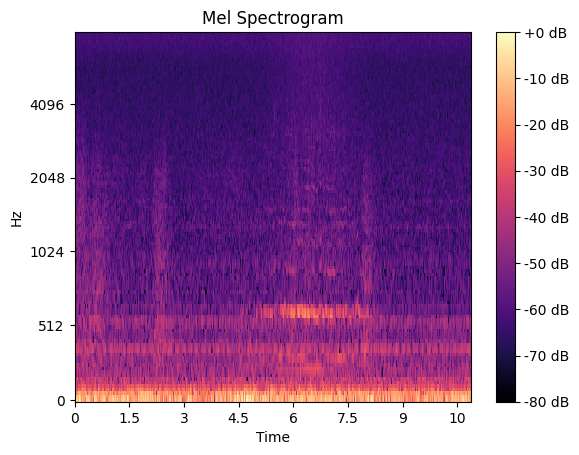

In [6]:
import librosa

full_audio, samplerate, sound_cat = long_sound_gen(1,noise_factor=1)

mel_spect = librosa.feature.melspectrogram(y=full_audio, sr=samplerate,
                                           n_fft=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time',
                         hop_length=256);
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

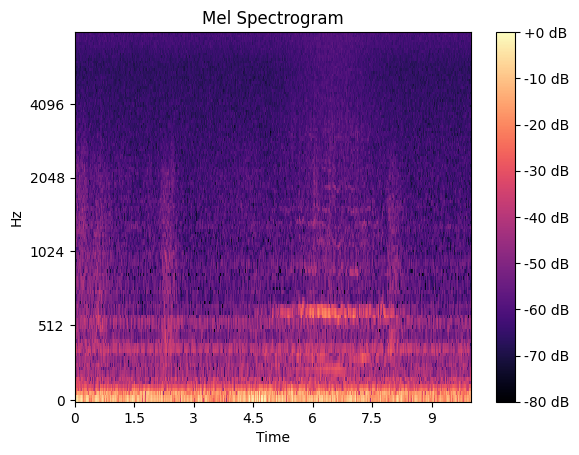

In [7]:
chopped_audio = chop_chop(full_audio,samplerate,10)
mel_spect = librosa.feature.melspectrogram(y=chopped_audio[0],
                                           sr=samplerate, n_fft=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000,
                         x_axis='time',hop_length=256);
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

## More helper functions

In [8]:
def generate_training_data(mosquitoness=1, noise_factor=0.5, chop_size=3):
  # Create the long mixed audio (mosquito + noise)
  full_audio, samplerate, sound_cat = long_sound_gen(mosquitoness,noise_factor)

  # Chop audio into X second clips
  chopped_audio = chop_chop(full_audio,samplerate,chop_size)

  # Create an average 'mosquitoness' of each clip
  chopped_cat = chop_chop(sound_cat,samplerate,chop_size)
  av_chopped_cat = np.mean(chopped_cat,axis=1)

  # Generate spectrogram for each clip
  spectro = np.zeros((len(chopped_audio),128,259))
  for i in range(0,len(chopped_audio)):
    mel_spect = librosa.feature.melspectrogram(y=chopped_audio[0],
                                               sr=samplerate, n_fft=1024)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    spectro[i] = mel_spect

  # Returns a number of seconds in audio x n_mfcc matrix and an array of sound category (how much mosquito) in each X second chop
  return spectro, av_chopped_cat

In [9]:
def multiple_training_data(amount_of_audio, mosquitoness=2, noise_factor=0.5,
                           chop_size=3):
  X, Y = generate_training_data(mosquitoness, noise_factor, chop_size)
  for i in range(0,amount_of_audio-1):
    specto, av_chopped_cat = generate_training_data(mosquitoness, noise_factor,
                                                   chop_size)
    X = np.concatenate((X,specto))
    Y = np.concatenate((Y,av_chopped_cat))
  return X,Y

## Convolutional Neural Network Demo

In [19]:
X,Y = multiple_training_data(100, mosquitoness=1, noise_factor=0.5, chop_size=3)

train/1564.wav has been extracted to ./drive/MyDrive/4YP/Data
train/738.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 7.499s
train/222801.wav has been extracted to ./drive/MyDrive/4YP/Data
train/838.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 5.324s
train/612.wav has been extracted to ./drive/MyDrive/4YP/Data
train/3464.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 21.481s
train/222801.wav has been extracted to ./drive/MyDrive/4YP/Data
train/3245.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 6.018s
train/222801.wav has been extracted to ./drive/MyDrive/4YP/Data
train/221032.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 8.213s
train/591.wav has been extracted to ./drive/MyDrive/4YP/Data
train/220431.wav has been extracted to ./drive/MyDrive/4YP/Data
Adding mosquito noise at 11.434s
train/817.wav has been extracted to ./drive/MyDrive/4YP/

In [24]:
print("Background Clips: ", np.count_nonzero(Y))
print("Mosquito Clips: ", len(Y)-np.count_nonzero(Y))
print("Total: ", len(Y))

Background Clips:  248
Mosquito Clips:  237
Total:  485


In [31]:
from sklearn.model_selection import train_test_split
Y = binarize(Y,thresh = 0)
X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=42)



X_train = X_train.reshape(-1, 128, 259, 1)
X_dev = X_dev.reshape(-1, 128, 259, 1)

print("Training set size: ", X_train.shape[0])
print("Validation set size: ", X_dev.shape[0])

Training set size:  388
Validation set size:  97


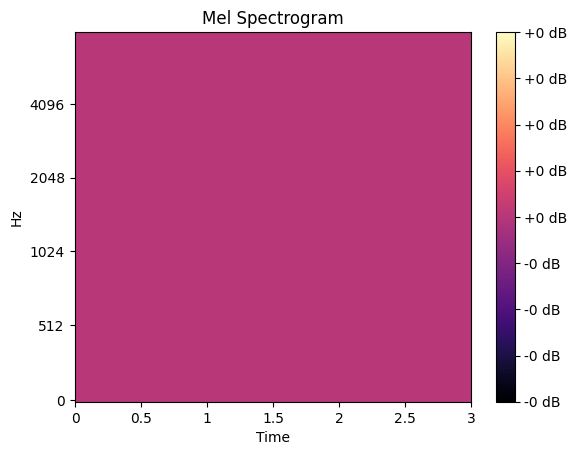

In [47]:
testy = X_train[0].reshape(128, 259)
mel_spect = librosa.power_to_db(testy, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000,
                         x_axis='time',hop_length=256);
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [43]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu",
                           input_shape=(128, 259, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 257, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 128, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 128, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 126, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 63, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 63, 64)        0

In [44]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              metrics=["accuracy"])

In [45]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_dev, y_dev))

Epoch 1/30
13/13 [==============================] - 2s 90ms/step - loss: 1018.6960 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.5361
Epoch 2/30
13/13 [==============================] - 1s 50ms/step - loss: 0.6933 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.5361
Epoch 3/30
13/13 [==============================] - 1s 44ms/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6934 - val_accuracy: 0.5361
Epoch 4/30
13/13 [==============================] - 1s 39ms/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.5361
Epoch 5/30
13/13 [==============================] - 1s 42ms/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6934 - val_accuracy: 0.5361
Epoch 6/30
13/13 [==============================] - 1s 41ms/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.5361
Epoch 7/30
13/13 [==============================] - 1s 43ms/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6935 - val_accuracy: 0.5361
Epoch 8/30